In [1]:
try:
  %tensorflow_version 2.x
except:
  pass

In [2]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import cv2

print(tf.__version__)

2.2.0


In [3]:
#Loading Mnist Digits Dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data(path="mnist.npz") 

In [4]:
data_dir = './Sudoku_Numbers'
digit_list = os.listdir(data_dir)
x_train = x_train.tolist()
y_train = y_train.tolist()


for digit in digit_list:
    digit_path = os.path.join(data_dir,digit)
    for img_name in os.listdir(digit_path):
        img = cv2.imread(os.path.join(digit_path,img_name), 0)
        x_train.append(img)
        y_train.append(int(digit))  


In [5]:
print("No of Total Traning images: ",len(x_train))

No of Total Traning images:  60708


In [6]:
x_train = np.array(x_train)
y_train = np.array(y_train)

In [7]:
def remove_zero_digit(img_arr,labels):
    index_val = np.where(labels == 0)
    #index_val = index_val.to_list()
    
    img_arr = np.delete(img_arr,index_val, axis=0)
    label_arr = np.delete(labels, index_val)
    
    return img_arr, label_arr


In [8]:
x_train, y_train = remove_zero_digit(x_train, y_train)
x_test, y_test = remove_zero_digit(x_test, y_test)

In [9]:
x_train = x_train.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)

x_train = x_train / 255.0
x_test = x_test / 255.0

y_train = y_train - 1
y_test = y_test - 1

In [10]:
# Data Preparation

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False,    # randomly flip images
        )     

datagen.fit(x_train)


In [11]:
batch_size = 86
epochs = 10
input_shape= (28,28,1)

In [12]:
# CNN Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D


model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',kernel_initializer='he_normal',input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',kernel_initializer='he_normal'))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(9, activation = "softmax"))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0

In [13]:
train_data_gen = datagen.flow(x_train, y_train, batch_size)

In [14]:
history = model.fit(train_data_gen, 
                    steps_per_epoch=len(x_train) / batch_size, 
                    epochs= epochs, 
                    validation_data= (x_test, y_test), 
                    validation_batch_size= batch_size)

Epoch 1/10
638/637 [==============================] - 139s 217ms/step - loss: 0.3353 - accuracy: 0.8919 - val_loss: 0.0398 - val_accuracy: 0.9876
Epoch 2/10
638/637 [==============================] - 154s 242ms/step - loss: 0.1133 - accuracy: 0.9654 - val_loss: 0.0263 - val_accuracy: 0.9916
Epoch 3/10
638/637 [==============================] - 136s 213ms/step - loss: 0.0903 - accuracy: 0.9729 - val_loss: 0.0188 - val_accuracy: 0.9942
Epoch 4/10
638/637 [==============================] - 132s 208ms/step - loss: 0.0798 - accuracy: 0.9770 - val_loss: 0.0207 - val_accuracy: 0.9939
Epoch 5/10
638/637 [==============================] - 132s 207ms/step - loss: 0.0755 - accuracy: 0.9780 - val_loss: 0.0246 - val_accuracy: 0.9917
Epoch 6/10
638/637 [==============================] - 147s 230ms/step - loss: 0.0745 - accuracy: 0.9786 - val_loss: 0.0197 - val_accuracy: 0.9945
Epoch 7/10
638/637 [==============================] - 138s 216ms/step - loss: 0.0738 - accuracy: 0.9795 - val_loss: 0.0178 -

In [15]:
model.save('digit_classifier.model')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: digit_classifier.model\assets


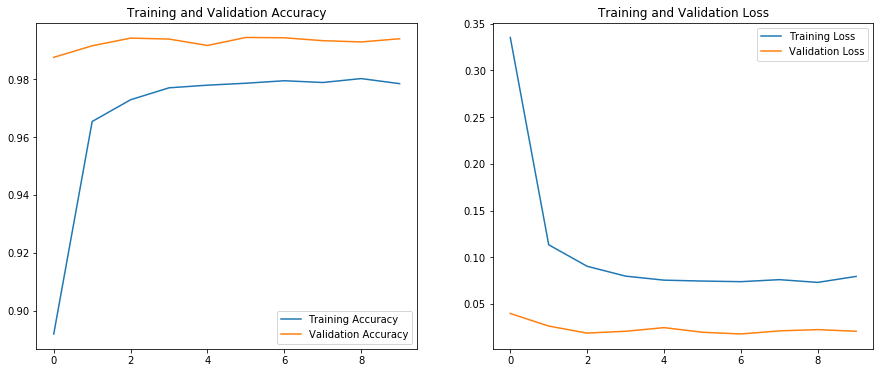

In [16]:
#Visualizing the results of Training

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('./train_eval.png')
plt.show()

In [23]:
#Combining both train and test data for fitting the final model
x_digit = np.vstack((x_train, x_test))
y_digit = np.concatenate((y_train, y_test))      

In [24]:
print("Shape of X: {} and Y: {}".format(x_digit.shape,y_digit.shape))

Shape of X: (63805, 28, 28, 1) and Y: (63805,)


In [25]:
final_data_gen = datagen.flow(x_digit, y_digit, batch_size)

In [26]:
history_final = model.fit(final_data_gen, 
                    steps_per_epoch=len(x_digit) / batch_size, 
                    epochs= epochs)

Epoch 1/10
742/741 [==============================] - 155s 208ms/step - loss: 0.0758 - accuracy: 0.9801
Epoch 2/10
742/741 [==============================] - 158s 213ms/step - loss: 0.0735 - accuracy: 0.9809
Epoch 3/10
742/741 [==============================] - 157s 212ms/step - loss: 0.0756 - accuracy: 0.9798
Epoch 4/10
742/741 [==============================] - 154s 207ms/step - loss: 0.0768 - accuracy: 0.9799
Epoch 5/10
742/741 [==============================] - 156s 210ms/step - loss: 0.0781 - accuracy: 0.9799
Epoch 6/10
742/741 [==============================] - 157s 212ms/step - loss: 0.0819 - accuracy: 0.9785
Epoch 7/10
742/741 [==============================] - 157s 211ms/step - loss: 0.0857 - accuracy: 0.9783
Epoch 8/10
742/741 [==============================] - 157s 212ms/step - loss: 0.0836 - accuracy: 0.9790
Epoch 9/10
742/741 [==============================] - 169s 227ms/step - loss: 0.0863 - accuracy: 0.9786
Epoch 10/10
742/741 [==============================] - 190s 256m

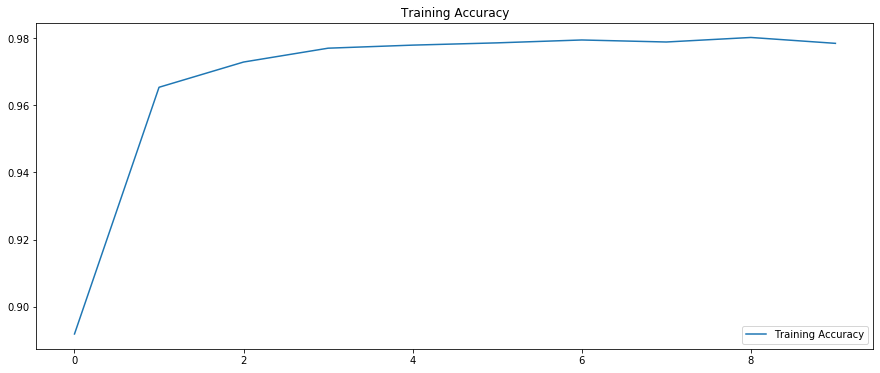

In [30]:
#Visualizing the results of Training

acc = history.history['accuracy']
loss = history.history['loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 6))
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.legend(loc='lower right')
plt.title('Training Accuracy')
plt.show()

In [27]:
model.save('Final_digit_classifier.model')

INFO:tensorflow:Assets written to: Final_digit_classifier.model\assets


In [29]:
import tensorflowjs as tfjs
tfjs.converters.save_keras_model(model, "tfjs_model")